### I. ImportData and Packages

In [1]:
import pandas as pd
import csv
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt


#Sklearn
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('clean_so2.csv')
df.head()

,Month,SO2_Con,SO2_AQI
0,Jan-15,1.362017,1.391732
1,Feb-15,1.168503,1.166921
2,Mar-15,1.389587,1.457938
3,Apr-15,1.266923,1.304955
4,May-15,0.905341,0.875688


### II. Converting the time data into a datetime object

In [3]:
dat = np.repeat(20, 72, axis=0).astype(str)  + df["Month"].astype(str) 
dat = pd.to_datetime(dat)
end = dat + pd.offsets.MonthBegin(1) - datetime.timedelta(days = 1)
df["Month"] = end
og = df
df.head()

,Month,SO2_Con,SO2_AQI
0,2015-01-31,1.362017,1.391732
1,2015-02-28,1.168503,1.166921
2,2015-03-31,1.389587,1.457938
3,2015-04-30,1.266923,1.304955
4,2015-05-31,0.905341,0.875688


The SVR model needs to use the date column, we need to code our date variable into a different format

In [4]:
df['Date'] = df['Month'].astype(str)
df['new_date'] = df['Month'].apply(lambda x: x.value)
df.head()

,Month,SO2_Con,SO2_AQI,Date,new_date
0,2015-01-31,1.362017,1.391732,2015-01-31,1422662400000000000
1,2015-02-28,1.168503,1.166921,2015-02-28,1425081600000000000
2,2015-03-31,1.389587,1.457938,2015-03-31,1427760000000000000
3,2015-04-30,1.266923,1.304955,2015-04-30,1430352000000000000
4,2015-05-31,0.905341,0.875688,2015-05-31,1433030400000000000


In [5]:
so2con = df['SO2_Con']
days = df['new_date']

### III. First I fit an svr model on randomly split training data

In [6]:
x1_train, x1_test, y1_train, y1_test = train_test_split(days, so2con, test_size=0.3)

In [7]:
x1_train = np.array(x1_train)
x1_test = np.array(x1_test)
x1_train =  x1_train.reshape(-1,1)
x1_test = x1_test.reshape(-1,1)

In [8]:
rbf = SVR(kernel = 'rbf')
rbf.fit(x1_train,y1_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [9]:
print('RMSE value of the SVR Model is:', np.sqrt(metrics.mean_squared_error(y1_test, rbf.predict(x1_test))))
print('R squared score of the SVR Model is: ', rbf.score(x1_train,y1_train))

RMSE value of the SVR Model is: 0.20715336262741216
R squared score of the SVR Model is:  0.11034303782788844


In [10]:
days1 = np.array(days)
days1 =  days1.reshape(-1,1)

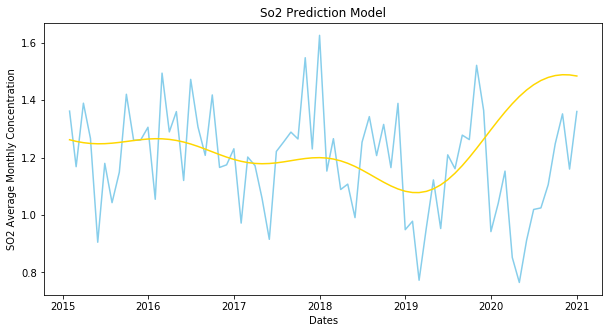

In [50]:
# Plot results
plt.figure(figsize=(10,5))
plt.title('So2 Prediction Model')
plt.xlabel('Dates')
plt.ylabel('SO2 Average Monthly Concentration')
plt.plot(df['Month'],so2con, color="skyblue")
plt.plot(df['Month'], rbf.predict(days1), color='gold')

The line is overly smoothed and does nto adequetly capture the fluctuations in the changes in parameters 

In [12]:
param = {'C' : [1,10,1000],'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale']},
modelsvr = SVR(kernel='rbf')
grids = GridSearchCV(modelsvr,param,cv=5)

In [13]:
grids.fit(x1_train, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=({'C': [1, 10, 1000],
                          'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale']},),
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [14]:
print("best parameters are: ", grids.best_params_)

best parameters are:  {'C': 1, 'gamma': 0.001}


In [54]:
best_rbf = SVR(kernel= 'rbf', C= 1, gamma = .001)
best_rbf.fit(x1_train,y1_train)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [55]:
print('RMSE value of the SVR Model is:', np.sqrt(metrics.mean_squared_error(y1_test, best_rbf.predict(x1_test))))
print('R squared score of the SVR Model is: ', best_rbf.score(x1_train,y1_train))

RMSE value of the SVR Model is: 0.2032265564658265
R squared score of the SVR Model is:  0.7623367912677301


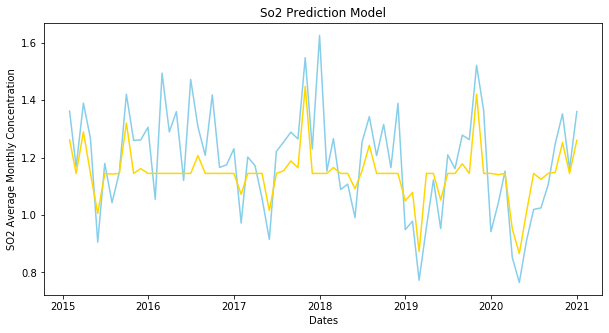

In [56]:
plt.figure(figsize=(10,5))
plt.title('So2 Prediction Model')
plt.xlabel('Dates')
plt.ylabel('SO2 Average Monthly Concentration')
plt.plot(df['Month'],so2con, color="skyblue")
plt.plot(df['Month'], best_rbf.predict(days1), color='gold')

The model fits the data much better! The R-Squared value increased from the original .11 value to .76. However, this model is only predicting values from the given date range it was trained on. We are trying to build a model that will forecast future SO2 values. 

### IV. Now I am splitting based on a time series index

In [18]:
days = np.array(days)
so2con = np.array(so2con)

In [19]:
tscv = TimeSeriesSplit()

In [20]:
for train_index, test_index in tscv.split(days):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = days[train_index], days[test_index]
    y_train, y_test = so2con[train_index], so2con[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12 13 14 15 16 17 18 19 20 21 22 23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24 25 26 27 28 29 30 31 32 33 34 35]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39 40 41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54 55 56 57 58 59]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59] TEST: [60 61 62 63 64 65 66 67 68 69 70 71]


In [21]:
x_train = np.array(X_train)
x_test = np.array(X_test)
x_train =  x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

In [22]:
len(x_train)

60

The length of the data is 60 rows, which includes 5 years of SO2 monthly averages. The last 12 months is going to be what the model will (hopefully) be able to predict. We can repeat the same method as before to get our resulting model. 

In [27]:
param = {'C' : [1,10,1000],'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale']},
modelsvr = SVR(kernel='rbf')
grids = GridSearchCV(modelsvr,param,cv=5)

In [28]:
grids.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=({'C': [1, 10, 1000],
                          'gamma': [0.001, 0.01, 0.1, 1, 'auto', 'scale']},),
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
print("best parameters are: ", grids.best_params_)

best parameters are:  {'C': 1, 'gamma': 0.001}


In [30]:
best_rbf = SVR(kernel= 'rbf', C= 1, gamma = 0.001)
best_rbf.fit(x_train,y_train)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [31]:
print('RMSE value of the SVR Model is:', np.sqrt(metrics.mean_squared_error(y_test, best_rbf.predict(x_test))))
print('R squared score of the SVR Model is: ', best_rbf.score(x_train,y_train))

RMSE value of the SVR Model is: 0.21358224026940026
R squared score of the SVR Model is:  0.782110675311956


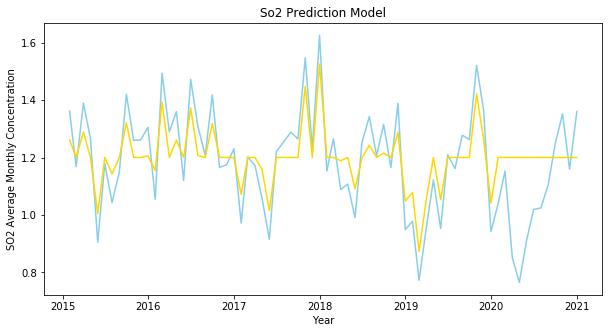

In [52]:
plt.figure(figsize=(10,5))
plt.title('So2 Prediction Model')
plt.xlabel('Year')
plt.ylabel('SO2 Average Monthly Concentration')
plt.plot(df['Month'],so2con, color="skyblue")
plt.plot(df['Month'], best_rbf.predict(days1), color='gold')


Unfortunately, this method was not an effective way of predicting future values for SO2. After Jan of 2020, the model went horizontal and predicted the same value for the rest of the year. 